In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
time_limit = 1

In [3]:
train_set = pd.read_csv('training_data.csv')
test_set = pd.read_csv('test_data.csv')

X_train = train_set.drop(columns='y')
Y_train = train_set['y']

X_test = test_set.drop(columns='y')
Y_test = test_set['y']

In [4]:
n = len(X_train)
m = X_train.shape[1]

### Lasso Regression and Cross Validation

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [6]:
lasso = LassoCV(cv = 10, random_state = 15, max_iter = 10000)
lasso.fit(X_train_sc,Y_train)
lasso.alpha_


0.08471942409934505

In [7]:
y_pred = lasso.predict(X_test_sc)
sse_test = np.sum((Y_test - y_pred) ** 2)

print(f"SSE on the test set: {sse_test}")

SSE on the test set: 117.83331916077937


In [8]:
selected_features = X_train.columns[lasso.coef_ != 0]
coefficients = lasso.coef_[lasso.coef_ != 0]

print("Selected features:")
print(selected_features)
print("Corresponding coefficients:")
print(coefficients)

Selected features:
Index(['X9', 'X11', 'X15', 'X16', 'X22', 'X23', 'X24', 'X26', 'X29', 'X33',
       'X34', 'X35', 'X39', 'X44', 'X45', 'X46', 'X47', 'X48'],
      dtype='object')
Corresponding coefficients:
[-2.71982685 -0.05745334 -0.39585533 -0.23276644 -0.22180365 -1.15847952
  0.77569425 -1.27950133  0.06530332 -0.10847216  0.25740072  0.01277731
 -0.18839793  0.0186891   1.63196351 -0.01838965  0.69384574 -0.08473514]


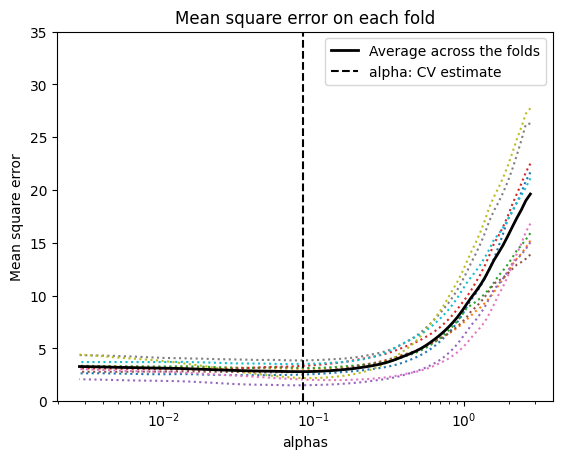

In [9]:
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(
    lasso.alphas_ ,
    lasso.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0, 35
plt.ylim(ymin, ymax);

### Using MIQP to Solve this problem

In [10]:
k_list = list(range(5, 51, 5))
n_folds = 10
M = 500 
row_per_fold = int(n/n_folds)
k_error = {}

for k in k_list:
    total_sse = 0
    for _ in range(n_folds):
        val_ind = np.random.choice(len(X_train), size=int(len(X_train) / n_folds), replace=False)
        train_ind = np.setdiff1d(np.arange(len(X_train)), val_ind)

        X_train_fold, X_val_fold = X_train.iloc[train_ind,:], X_train.iloc[val_ind,:]
        y_train_fold, y_val_fold = Y_train[train_ind], Y_train[val_ind]

        qp = gp.Model()
        beta = qp.addMVar(m+1,lb=-np.inf)
        z = qp.addMVar(m, vtype = 'B')
        qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i]) 
                                    * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
                                     for i in range(len(X_train_fold))))

        con1 = qp.addConstr(gp.quicksum(z[j] for j in range(m)) <= k )
        con2 = qp.addConstrs(beta[j+1] <= M*z[j] for j in range(m))
        con3 = qp.addConstrs(beta[j+1] >= -M*z[j] for j in range(m))

        qp.Params.OutputFlag = 0
        qp.setParam('TimeLimit', time_limit)
        qp.optimize()
        
        val_error = 0
        opt_beta = list(beta.x)
        for i in range(len(X_val_fold)):
            inner_sum = 0
            for j in range(m):
                inner_sum += opt_beta[j + 1] * X_val_fold.iloc[i, j]
    
            val_error += ((opt_beta[0] + inner_sum) - y_val_fold.iloc[i])*((opt_beta[0] + inner_sum) - y_val_fold.iloc[i])
        print(val_error)
        total_sse += val_error
    print(f"SSE on validation set for k = {k} is {total_sse/n_folds}") 
    k_error[k] = total_sse/n_folds

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-19


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


94.0489408266418


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


72.39310902170537


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


83.61695781713993


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


152.52254614409165


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


109.86655991809165


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


108.4589719137509


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


54.694033433504934


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


72.72222805670349


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


63.9172211596133


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


158.5999202675009
SSE on validation set for k = 5 is 97.08404885587439


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


64.8908751029952


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


88.98472187146054


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


51.89316697817615


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


50.52039815668439


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


56.04739992986565


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


67.36641491879654


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


84.373896964885


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


68.70915869850262


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


98.12524924501399


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


61.50970339900963
SSE on validation set for k = 10 is 69.24209852653897


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


97.73379597658366


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


79.94406166110934


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


83.01292399166671


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


102.84390065593695


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


80.41504929624695


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


67.38285407897497


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


74.06440541825805


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


84.02577917379885


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


93.54298351368774


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


38.977328704074736
SSE on validation set for k = 15 is 80.19430824703379


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


74.54993345228675


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


80.71414383334043


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


80.09283860890474


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


61.90172311904217


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


121.14986306891932


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


76.53671419335737


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


62.622721762413676


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


76.16979397550412


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


94.40988232564473


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


60.869024095044416
SSE on validation set for k = 20 is 78.90166384344579


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


58.40223708627933


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


73.29670027366154


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


117.97777078510215


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


82.30608044761175


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


119.89792949083807


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


81.73714448296833


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


66.8140506801956


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


108.85863527720224


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


61.70571164882774


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


108.63726606866695
SSE on validation set for k = 25 is 87.96335262413537


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


64.24256743642556


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


65.79123563693898


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


125.58242060405894


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


109.42032153681639


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


92.48239005541494


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


135.29675497209382


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


41.08782103292155


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


113.44607167395165


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


77.95365243279998


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


76.7798030799327
SSE on validation set for k = 30 is 90.20830384613545


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


74.76743251897008


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


83.3118912222421


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


85.57183494468131


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


94.03531107525441


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


60.55238594335849


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


89.05762961807287


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


58.866517016221955


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


107.32121611624733


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


75.13091850608575


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


77.40409300138596
SSE on validation set for k = 35 is 80.60192299625203


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


142.95235885623694


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


86.08002401733086


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


81.37251054603766


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


79.34159790069683


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


68.48734067889608


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


94.60324250282972


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


84.7423830769374


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


96.340093271513


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


84.11942846900294


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


59.08416219098596
SSE on validation set for k = 40 is 87.71231415104674


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


92.42328510833981


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


77.70274136129717


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


59.34957549479826


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


113.76033111600292


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


78.5738790552654


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


52.375542742024166


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


85.33561805083664


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


62.627524425169746


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


90.22241633170952


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


114.30028295124002
SSE on validation set for k = 45 is 82.66711966366837


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


66.54764886686749


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


62.44815192254617


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


63.23941786330996


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


111.3735230582229


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


109.9496194607003


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


78.13082228451728


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


97.61227066337686


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


71.49179524569391


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


84.84412267161112


C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\2705902577.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])


46.83660395744222
SSE on validation set for k = 50 is 79.24739759942882


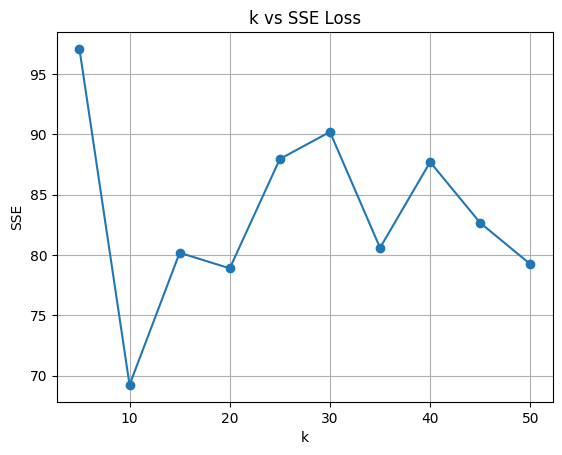

In [11]:
k_vals = list(k_error.keys())
loss_vals = list(k_error.values())

# Plotting
plt.plot(k_vals, loss_vals, marker='o', linestyle='-')
plt.title('k vs SSE Loss')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

### Training the model on best k

In [12]:
min_k = min(k_error, key=lambda k: k_error[k])

In [13]:
M=500
qp = gp.Model()
beta = qp.addMVar(m+1,lb=-np.inf)
z = qp.addMVar(m, vtype = 'B')
qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train.iloc[i][j] for j in range(m)) - Y_train.iloc[i]) 
                            * (beta[0] + gp.quicksum(beta[j+1]*X_train.iloc[i][j] for j in range(m)) - Y_train.iloc[i])
                            for i in range(len(X_train))))

con1 = qp.addConstr(gp.quicksum(z[j] for j in range(m)) <= min_k )
con2 = qp.addConstrs(beta[j+1] <= M*z[j] for j in range(m))
con3 = qp.addConstrs(beta[j+1] >= -M*z[j] for j in range(m))

qp.Params.OutputFlag = 0
qp.setParam('TimeLimit', time_limit)
qp.optimize()

opt_beta = list(beta.x)
y_pred_miqp = []
val_error = 0
for i in range(len(X_test)):
    inner_sum = 0
    for j in range(m):
        inner_sum += opt_beta[j + 1] * X_test.iloc[i, j]
    pred = inner_sum + opt_beta[0]
    y_pred_miqp.append(pred)
    val_error += (Y_test.iloc[i] - (opt_beta[0] + inner_sum))*(Y_test.iloc[i] - (opt_beta[0] + inner_sum))

print(f"SSE on test set for k = {min_k} is {val_error}") 

C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\3002903194.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train.iloc[i][j] for j in range(m)) - Y_train.iloc[i])
C:\Users\nikna\AppData\Local\Temp\ipykernel_14212\3002903194.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  * (beta[0] + gp.quicksum(beta[j+1]*X_train.iloc[i][j] for j in range(m)) - Y_train.iloc[i])


SSE on test set for k = 10 is 116.82719822762628


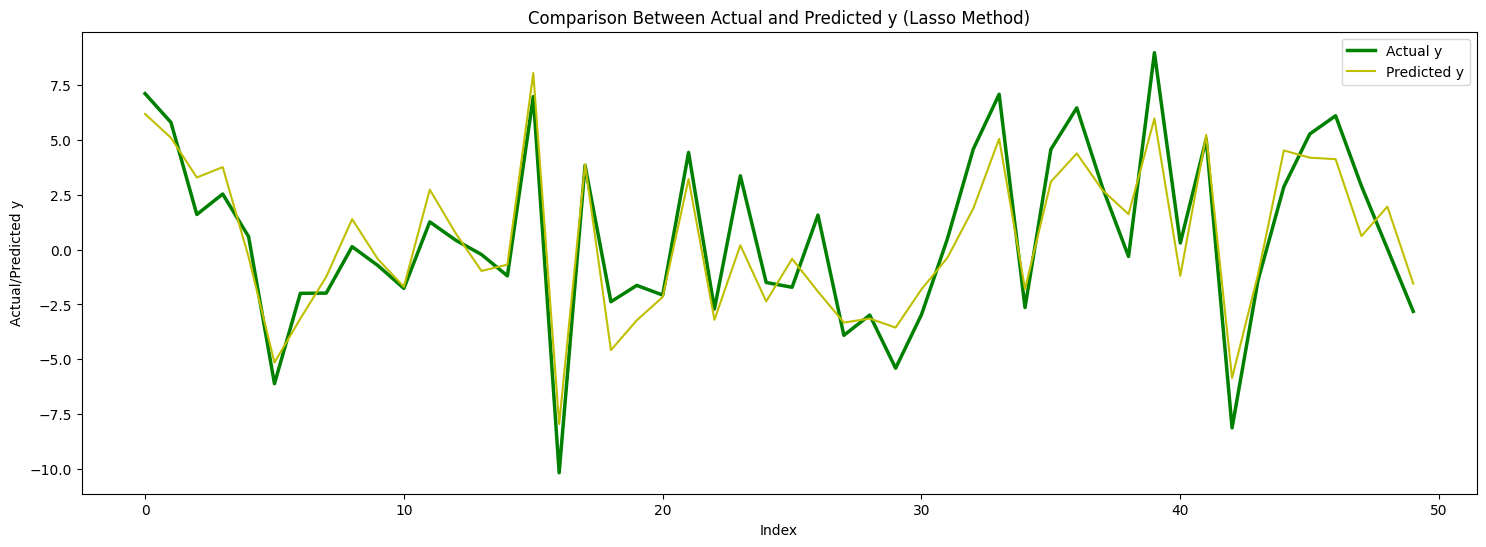

In [14]:
plt.figure(figsize=(18,6))
plt.plot(Y_test.index, Y_test, color='g', label='Actual y', linewidth=2.5)
plt.plot(Y_test.index, y_pred_miqp, color='y', label='Predicted y')
plt.xlabel('Index')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y (Lasso Method)')
plt.legend()
plt.show()